# Freesound General-Purpose Audio Tagging Challenge - Random Forest and MFCC
<br>
Last update: 19 June 2019<br> 

<br>

**Backgound.**

The challenge is to build a general-purpose automatic audio tagging system using a dataset of audio files covering a wide range of real-world environments. Sounds in the dataset include things like musical instruments, human sounds, domestic sounds, and animals from Freesound’s library, annotated using a vocabulary of more than 40 labels from Google’s AudioSet ontology.

**Data fields.**

Each row of the train.csv file contains the following information:

- **fname:** the file name
- **label:** the audio classification label (ground truth)
- **manually_verified:** Boolean (1 or 0) flag to indicate whether or not that annotation has been manually verified
<br>
Dataset: [Freesound General-Purpose Audio Tagging Challenge 2018](https://www.kaggle.com/c/freesound-audio-tagging)

___


# This Notebook (**Bark** - **Meow**)

In this notebook features, [Mel Frequency Ceptral Coefficient (MFCC)](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum), are extracted from the audio signal and a classification (Random Forest) will be performed, only two labels are selected, **Bark** and **Meow**.

___

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa.display
from scipy.io import wavfile

import os
import IPython.display
import sklearn
import itertools

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

%matplotlib inline

In [2]:
if os.name == 'nt':
    print("windows")
    PATH_AUDIOWAV_TRAIN = "./data/audio_train/"
    PATH_METADATA = "./data/train_post_competition.csv"
else:
    print("macOS")
    PATH_AUDIOWAV_TRAIN = "./data/audio_train/"
    PATH_METADATA = "./data/train_post_competition.csv"

windows


In [25]:
# ref.: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [3]:
class AudioClip:
    def __init__(self, path):
        '''
        :param fs: sample rata
        :param data: audio
        '''
        samples, fs = librosa.load(path)
        self.fs = fs
        self.samples = samples
        
    def plot_waveform(self):
        '''
        plot the audioclip.
        '''
        plt.plot(np.arange(0, len(self.samples))/self.fs, self.samples)
        plt.grid()
        plt.show()
        
    def get_fs(self):
        '''
        return the audio clip sample frequency, fs
        '''
        return self.fs
    
    def get_samples(self):
        '''
        return the samples of the audio clip
        '''
        return self.samples
    
    # MFCC features
    def get_logamplitude_melspectrogram(self):
        return librosa.power_to_db(self.get_melspectrogram())
    
    def get_melspectrogram(self):
        return librosa.feature.melspectrogram(self.samples, sr = self.fs)
    
    def get_mfcc(self, n_mfcc):
        return librosa.feature.mfcc(S=self.get_logamplitude_melspectrogram(), n_mfcc = n_mfcc).transpose()
    
    def get_scaled_mean_mfcc(self, n_mfcc):
        mfcc_scale = sklearn.preprocessing.scale(self.get_mfcc(n_mfcc), axis=1)
        # Take the mean 
        return mfcc_scale.mean(axis=0)

In [4]:
meta_data = pd.read_csv(PATH_METADATA)
meta_data.head()

,fname,label,manually_verified,freesound_id,license
0,00044347.wav,Hi-hat,0,28739,Attribution
1,001ca53d.wav,Saxophone,1,358827,Attribution
2,002d256b.wav,Trumpet,0,10897,Creative Commons 0
3,0033e230.wav,Glockenspiel,1,325017,Attribution
4,00353774.wav,Cello,1,195688,Attribution


In [5]:
print('Number of wave file in the train dataset:', meta_data.shape[0])

Number of wave file in the train dataset: 9473


## Labels

In [6]:
# list of labels
print(list(meta_data.label.value_counts().index))

['Saxophone', 'Snare_drum', 'Laughter', 'Tearing', 'Flute', 'Cello', 'Fart', 'Violin_or_fiddle', 'Shatter', 'Clarinet', 'Hi-hat', 'Squeak', 'Trumpet', 'Fireworks', 'Double_bass', 'Bass_drum', 'Acoustic_guitar', 'Applause', 'Oboe', 'Gong', 'Knock', 'Writing', 'Cough', 'Bark', 'Tambourine', 'Burping_or_eructation', 'Cowbell', 'Harmonica', 'Drawer_open_or_close', 'Meow', 'Electric_piano', 'Gunshot_or_gunfire', 'Microwave_oven', 'Keys_jangling', 'Telephone', 'Computer_keyboard', 'Finger_snapping', 'Chime', 'Bus', 'Scissors', 'Glockenspiel']


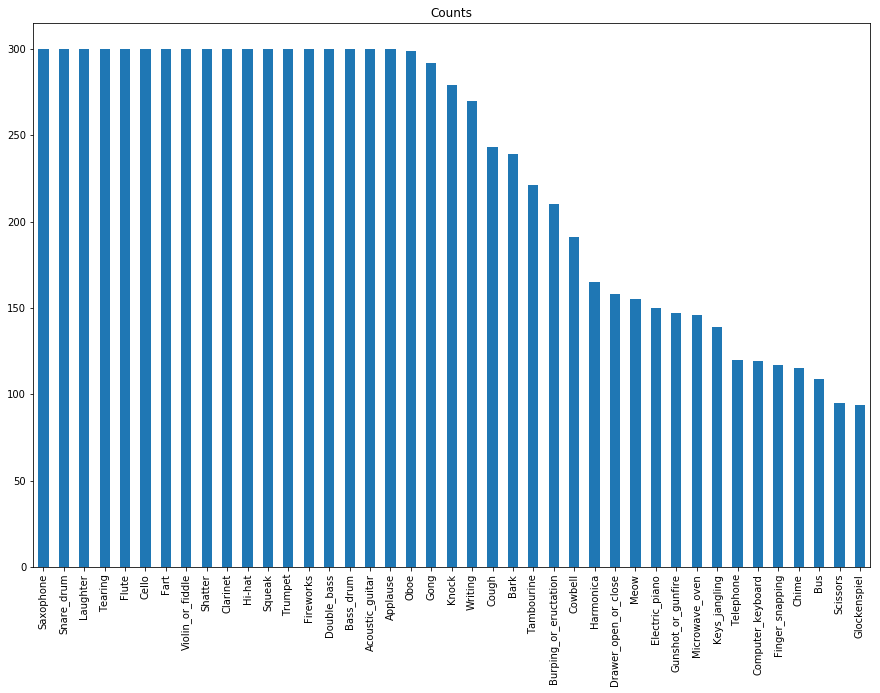

In [7]:
plt.figure(figsize=(15,10))
meta_data.label.value_counts().plot(kind='bar', title='Counts');

## Audio clip

### Plot clip

754667cd.wav
Category: Meow


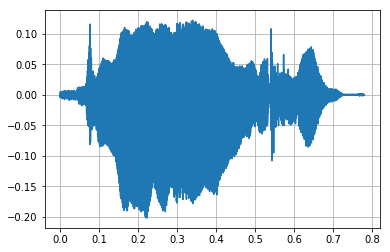

In [8]:
file_number = 4325

print(meta_data.fname[file_number])
print('Category:', meta_data.label[file_number])

AudioClip(PATH_AUDIOWAV_TRAIN + meta_data.fname[file_number]).plot_waveform()

IPython.display.Audio(AudioClip(PATH_AUDIOWAV_TRAIN + meta_data.fname[file_number]).get_samples(), rate = AudioClip(PATH_AUDIOWAV_TRAIN + meta_data.fname[file_number]).get_fs())

### MFCC

[Mel Frequency Ceptral Coefficient (MFCC)](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) 

754667cd.wav
Category: Meow


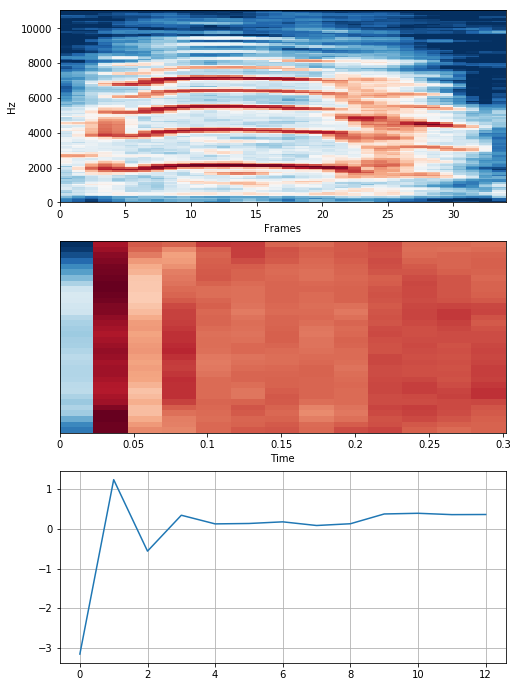

In [9]:
file_number = 4325

print(meta_data.fname[file_number])
print('Category:', meta_data.label[file_number])

signal = AudioClip(PATH_AUDIOWAV_TRAIN + meta_data.fname[file_number])

n_mfcc = 13

plt.figure(figsize=(8,12))

plt.subplot(3,1,1)
librosa.display.specshow(signal.get_logamplitude_melspectrogram(), sr=signal.get_fs(), x_axis='frames', y_axis='linear', cmap='RdBu_r');

plt.subplot(3,1,2)
librosa.display.specshow(signal.get_mfcc(n_mfcc), sr=signal.get_fs(), x_axis='time', cmap='RdBu_r');

plt.subplot(3,1,3)
plt.plot(signal.get_scaled_mean_mfcc(n_mfcc));
plt.grid()

## *.Wav selection

The two labels are: **Bark** and **Meow**.

In [10]:
meta_data_bark_meow = meta_data[meta_data.label.isin(['Bark','Meow'])]
meta_data_bark_meow.head()

,fname,label,manually_verified,freesound_id,license
27,00e2b4cd.wav,Bark,1,344955,Creative Commons 0
54,019d2a2c.wav,Bark,1,89211,Creative Commons 0
70,020eb9f6.wav,Bark,1,4910,Attribution
94,027cd3fd.wav,Meow,1,118522,Creative Commons 0
125,03b4aca1.wav,Meow,1,203121,Attribution


In [11]:
meta_data_bark_meow.label.value_counts()

Bark    239
Meow    155
Name: label, dtype: int64

In [12]:
count = meta_data_bark_meow.label.value_counts()
print('% Bark:', 100* count.tolist()[0]/meta_data_bark_meow.shape[0])
print('% Meow:', 100* count.tolist()[1]/meta_data_bark_meow.shape[0])

% Bark: 60.65989847715736
% Meow: 39.34010152284264


Ratio: Bark/Meow is 60/40. 

## Extract feature

In [13]:
n_mfcc = 13
index = np.array(meta_data_bark_meow.index)

df = pd.DataFrame(columns=['filename', 'MFCC0', 'MFCC1', 'MFCC2', 'MFCC3', 'MFCC4', 'MFCC5', 'MFCC6','MFCC7', 'MFCC8', 'MFCC9', 'MFCC10', 'MFCC11', 'MFCC12', 'label'])

for index_value in range(len(index)):
    path = PATH_AUDIOWAV_TRAIN+meta_data_bark_meow.fname[index[index_value]]
    print('File:', index[index_value], ', Path:', path, ', label:', meta_data_bark_meow.label[index[index_value]])
    
    signal = AudioClip(path)
    
    # print(list(mfcc_scale_mean_feature(path)))
    # reference: https://stackoverflow.com/questions/10715965/add-one-row-to-pandas-dataframe
    df.loc[index[index_value]] = [meta_data_bark_meow.fname[index[index_value]]] + list(signal.get_scaled_mean_mfcc(n_mfcc)) + [meta_data_bark_meow.label[index[index_value]]]
    
df.head()

File: 27 , Path: ./data/audio_train/00e2b4cd.wav , label: Bark
File: 54 , Path: ./data/audio_train/019d2a2c.wav , label: Bark
File: 70 , Path: ./data/audio_train/020eb9f6.wav , label: Bark
File: 94 , Path: ./data/audio_train/027cd3fd.wav , label: Meow
File: 125 , Path: ./data/audio_train/03b4aca1.wav , label: Meow
File: 152 , Path: ./data/audio_train/0457d8bc.wav , label: Bark
File: 162 , Path: ./data/audio_train/04ab05a7.wav , label: Bark
File: 175 , Path: ./data/audio_train/05173c4d.wav , label: Bark
File: 231 , Path: ./data/audio_train/06dd3b18.wav , label: Bark
File: 233 , Path: ./data/audio_train/06e87b61.wav , label: Bark
File: 241 , Path: ./data/audio_train/0704ffb8.wav , label: Bark
File: 260 , Path: ./data/audio_train/07605b4c.wav , label: Bark
File: 293 , Path: ./data/audio_train/086dfaff.wav , label: Bark
File: 308 , Path: ./data/audio_train/08cf2d2b.wav , label: Bark
File: 321 , Path: ./data/audio_train/0939d783.wav , label: Bark
File: 330 , Path: ./data/audio_train/098a320

File: 3005 , Path: ./data/audio_train/511fb54a.wav , label: Bark
File: 3024 , Path: ./data/audio_train/519b068d.wav , label: Bark
File: 3043 , Path: ./data/audio_train/52127914.wav , label: Meow
File: 3077 , Path: ./data/audio_train/52efdfdd.wav , label: Meow
File: 3129 , Path: ./data/audio_train/546416c0.wav , label: Bark
File: 3155 , Path: ./data/audio_train/54f4ed65.wav , label: Bark
File: 3180 , Path: ./data/audio_train/55b7b452.wav , label: Meow
File: 3215 , Path: ./data/audio_train/569ee690.wav , label: Bark
File: 3239 , Path: ./data/audio_train/574d304d.wav , label: Bark
File: 3286 , Path: ./data/audio_train/58c581a3.wav , label: Bark
File: 3317 , Path: ./data/audio_train/59667f26.wav , label: Bark
File: 3344 , Path: ./data/audio_train/5a4404c9.wav , label: Bark
File: 3359 , Path: ./data/audio_train/5aa8b633.wav , label: Meow
File: 3360 , Path: ./data/audio_train/5aabae55.wav , label: Bark
File: 3393 , Path: ./data/audio_train/5baff24a.wav , label: Bark
File: 3482 , Path: ./data

File: 6506 , Path: ./data/audio_train/b1e3de31.wav , label: Meow
File: 6511 , Path: ./data/audio_train/b206d981.wav , label: Meow
File: 6529 , Path: ./data/audio_train/b2ba9028.wav , label: Meow
File: 6589 , Path: ./data/audio_train/b41d03ad.wav , label: Bark
File: 6614 , Path: ./data/audio_train/b4c891db.wav , label: Meow
File: 6640 , Path: ./data/audio_train/b54cc509.wav , label: Meow
File: 6673 , Path: ./data/audio_train/b6383321.wav , label: Bark
File: 6702 , Path: ./data/audio_train/b6f5bb24.wav , label: Bark
File: 6708 , Path: ./data/audio_train/b7169927.wav , label: Bark
File: 6744 , Path: ./data/audio_train/b7f2e8ad.wav , label: Bark
File: 6747 , Path: ./data/audio_train/b7fbbe04.wav , label: Bark
File: 6749 , Path: ./data/audio_train/b808471e.wav , label: Bark
File: 6861 , Path: ./data/audio_train/bb1e58c6.wav , label: Bark
File: 6880 , Path: ./data/audio_train/bb5e623d.wav , label: Meow
File: 6918 , Path: ./data/audio_train/bc9449d2.wav , label: Bark
File: 6931 , Path: ./data

File: 9236 , Path: ./data/audio_train/f9907471.wav , label: Meow
File: 9239 , Path: ./data/audio_train/f9a4b662.wav , label: Meow
File: 9253 , Path: ./data/audio_train/fa2786f2.wav , label: Bark
File: 9286 , Path: ./data/audio_train/faf61d4f.wav , label: Meow
File: 9291 , Path: ./data/audio_train/fb14cf7c.wav , label: Bark
File: 9297 , Path: ./data/audio_train/fb359da1.wav , label: Bark
File: 9333 , Path: ./data/audio_train/fc35ee0b.wav , label: Meow
File: 9343 , Path: ./data/audio_train/fc800c19.wav , label: Meow
File: 9366 , Path: ./data/audio_train/fd1ae06f.wav , label: Meow
File: 9441 , Path: ./data/audio_train/ff4ea3fe.wav , label: Meow


,filename,MFCC0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,MFCC11,MFCC12,label
27,00e2b4cd.wav,-3.369111,0.874723,0.180767,0.128674,0.154935,0.233266,0.194008,0.257196,0.269058,0.253215,0.262623,0.262478,0.298167,Bark
54,019d2a2c.wav,-2.583894,1.467600,-0.569302,-0.246995,-0.057985,0.133803,0.175074,0.373914,0.324229,0.345691,0.173544,0.395981,0.068341,Bark
70,020eb9f6.wav,-2.496982,2.115355,-0.254014,-0.159946,-0.024283,0.021379,0.075237,0.203116,-0.062294,0.061994,0.042210,0.285447,0.192780,Bark
94,027cd3fd.wav,-3.405794,0.804021,0.194733,0.266863,0.272010,0.310634,0.149319,0.290130,0.208531,0.228281,0.254735,0.283332,0.143205,Meow
125,03b4aca1.wav,-3.263657,0.912580,0.089816,0.246827,0.103184,0.262990,0.038898,0.410280,0.336678,0.419111,0.270038,0.122677,0.050578,Meow


In [14]:
df.to_csv('./data/feature_dataset.csv')

## Classification - Random forest

### Cleaning

In [16]:
# Remove columns filename and MFCC0
df =  df.drop(['filename', 'MFCC0'], axis = 1)
df.head()

,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,MFCC11,MFCC12,label
27,0.874723,0.180767,0.128674,0.154935,0.233266,0.194008,0.257196,0.269058,0.253215,0.262623,0.262478,0.298167,Bark
54,1.467600,-0.569302,-0.246995,-0.057985,0.133803,0.175074,0.373914,0.324229,0.345691,0.173544,0.395981,0.068341,Bark
70,2.115355,-0.254014,-0.159946,-0.024283,0.021379,0.075237,0.203116,-0.062294,0.061994,0.042210,0.285447,0.192780,Bark
94,0.804021,0.194733,0.266863,0.272010,0.310634,0.149319,0.290130,0.208531,0.228281,0.254735,0.283332,0.143205,Meow
125,0.912580,0.089816,0.246827,0.103184,0.262990,0.038898,0.410280,0.336678,0.419111,0.270038,0.122677,0.050578,Meow


In [17]:
# check missing values
print('Columns with missing values:', df.isnull().any().sum())

Columns with missing values: 0


In [18]:
# List of features
features = df.columns.values[0:len(df.columns.values)-1]
print(list(features))

['MFCC1', 'MFCC2', 'MFCC3', 'MFCC4', 'MFCC5', 'MFCC6', 'MFCC7', 'MFCC8', 'MFCC9', 'MFCC10', 'MFCC11', 'MFCC12']


### Dataset split

In [19]:
X = df[features]
y = df['label']

In [22]:
# Train:Test, ratio 75:25
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=0)

### Random forest

In [24]:
max_depth = None
max_leaf_nodes = None
n_estimators = 500 # number of trees

# Create a random forest Classifier
clf =  RandomForestClassifier(max_depth = max_depth, max_leaf_nodes = max_leaf_nodes, n_estimators = n_estimators, 
                             random_state = 20, n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# predict class labels for samples in the validation set
y_pred = clf.predict(X_val)

# Confusion matrix
cnf_matrix = metrics.confusion_matrix(y_val, y_pred)

# parameters used by current model
parameters_RandomForestClassifier = clf.get_params()
print(parameters_RandomForestClassifier)

print('')
print("Accuracy:",100*round(metrics.accuracy_score(y_val, y_pred),3))


{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'oob_score': False, 'random_state': 20, 'verbose': 0, 'warm_start': False}

Accuracy: 86.9


Normalized confusion matrix


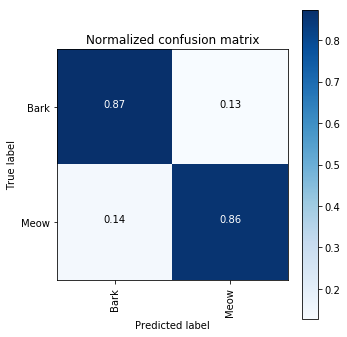

In [30]:
class_labels = list(df.label.value_counts().index)

# Plot normalized confusion matrix
plt.figure(figsize =(5,5))
plot_confusion_matrix(cnf_matrix, classes=class_labels, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# [EOF]